In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import os
import warnings
from collections import OrderedDict
import pandas as pd
import re

In [25]:
'''# things to import for Joe's code to work
from scipy.ndimage.measurements import center_of_mass

import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import LinearRing, MultiPoint, MultiPolygon

import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, RIVERS

from shapely.geometry.point import Point
import shapely.geometry as geometry
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math

from descartes import PolygonPatch

scale = '50m'

plt.rcParams.update({'mathtext.default':  'regular' })'''

"# things to import for Joe's code to work\nfrom scipy.ndimage.measurements import center_of_mass\n\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\nfrom shapely.geometry import LinearRing, MultiPoint, MultiPolygon\n\nimport cartopy\nimport cartopy.crs as ccrs\nfrom cartopy.feature import NaturalEarthFeature, RIVERS\n\nfrom shapely.geometry.point import Point\nimport shapely.geometry as geometry\nfrom shapely.ops import cascaded_union, polygonize\nfrom scipy.spatial import Delaunay\nimport numpy as np\nimport math\n\nfrom descartes import PolygonPatch\n\nscale = '50m'\n\nplt.rcParams.update({'mathtext.default':  'regular' })"

In [26]:
'''class Rasm(ccrs.Projection):

    def __init__(self):

        proj4_params = {'R': 6371200.0,
                        'lat_0': 90.0,
                        'lat_1': 90,
                        'lat_2': 90,
                        'lon_0': -114.0+360,
                        'proj': 'lcc',
                        'units': 'm',
                        'x_0': 9469302.950316086,
                        'y_0': 6201952.603370549}

        super(Rasm, self).__init__(proj4_params)

    @property
    def boundary(self):
        coords = ((self.x_limits[0], self.y_limits[0]),(self.x_limits[1], self.y_limits[0]),
                  (self.x_limits[1], self.y_limits[1]),(self.x_limits[0], self.y_limits[1]),
                  (self.x_limits[0], self.y_limits[0]))

        return ccrs.sgeom.Polygon(coords).exterior

    @property
    def threshold(self):
        return 100000.0

    @property
    def x_limits(self):
        return (0, 16423961.103252266)

    @property
    def y_limits(self):
        return (0, 12228062.194885937)'''

"class Rasm(ccrs.Projection):\n\n    def __init__(self):\n\n        proj4_params = {'R': 6371200.0,\n                        'lat_0': 90.0,\n                        'lat_1': 90,\n                        'lat_2': 90,\n                        'lon_0': -114.0+360,\n                        'proj': 'lcc',\n                        'units': 'm',\n                        'x_0': 9469302.950316086,\n                        'y_0': 6201952.603370549}\n\n        super(Rasm, self).__init__(proj4_params)\n\n    @property\n    def boundary(self):\n        coords = ((self.x_limits[0], self.y_limits[0]),(self.x_limits[1], self.y_limits[0]),\n                  (self.x_limits[1], self.y_limits[1]),(self.x_limits[0], self.y_limits[1]),\n                  (self.x_limits[0], self.y_limits[0]))\n\n        return ccrs.sgeom.Polygon(coords).exterior\n\n    @property\n    def threshold(self):\n        return 100000.0\n\n    @property\n    def x_limits(self):\n        return (0, 16423961.103252266)\n\n    @proper

load data 

In [27]:
dpi = 200
workdir = os.getcwd()
# monthly flux files 
monthly_filename = 'fluxes_monthly4.1978-01.nc'
daily_filename = 'fluxes_daily4.1978-01-01.nc'
domain_file = 'calm_domain_file_adj_11282016.nc'
params_ncfile = 'params_calm_sites_11282016.nc'
mo_fluxes = xr.open_dataset(os.path.join(workdir, monthly_filename))
day_fluxes = xr.open_dataset(os.path.join(workdir, daily_filename))
domain = xr.open_dataset(os.path.join(workdir, domain_file))

# load separate copy of the domain file to alter with thaw depths for obs and model runs (one for each, 
# can then calculate the difference but I want to see both independently too)
sim_thaw_depths = xr.open_dataset(os.path.join(workdir, domain_file))
obs_thaw_depths = xr.open_dataset(os.path.join(workdir, domain_file))

# parameters
params = xr.open_dataset(os.path.join(workdir, params_ncfile))
# statefile to get node depths
node_statefile = 'node_depth.19780102_00000.nc'
node_state = xr.open_dataset(os.path.join(workdir, node_statefile))
# obs from CALM network
thaw_depths_file = 'thaw_depths.csv'
thaw_depths = pd.read_csv(os.path.join(workdir, thaw_depths_file), 
                          delimiter=',', 
                         header=None, 
                         error_bad_lines=False, 
                         nrows=236, 
                         encoding='ISO-8859-1')
calm_metadata = 'CALM_Summary_table_latslons.csv'

# read in data
calm = pd.read_csv(os.path.join(workdir, calm_metadata), 
                   delimiter=',',
                   header=0,
                   error_bad_lines=False,
                   nrows=236,
                   encoding='ISO-8859-1')

# rename columns 
calm.rename(index=str, columns={"LAT": "lat", "LONG": "lng"}, inplace=True)

this function is taken from my metadata notebook, read_calm_metadata.ipynb

In [28]:
def parse_calm_lat_or_lon(x):
    '''takes in lat or lon from CALM data and produces list of degree, minutes, seconds
    or decimal. If element is a decimal, returns decimal as a float. If not decimal, 
    or decimal with direction, it returns a decimal without the direction as a float'''
    # symbols to parse by
    upside_down_exc = '¡'
    degree_sign= u'\N{DEGREE SIGN}'
    single_quote = "'"
    double_quote = '''"'''
    space = " "
    comma = ","
    v = 'v'
    zero_aigu = calm['lat'][70][8]
    # combine all symbols into one reg ex
    split_on = '%s|\s|%s|%s|%s|%s|%s|%s|%s|' % (upside_down_exc, degree_sign, single_quote, 
                                             double_quote, space, comma, v, zero_aigu)
    # parse lat or lon with reg ex 
    splitt = re.split(split_on, x)

    # remove comma and v characters from strings in parsed list 
    chars_to_remove = [',' 'v']
    for char_to_remove in chars_to_remove:
        if char_to_remove in splitt: 
            splitt.remove(char_to_remove)
            
    # remove empty strings from parsed list 
    parsed_list = list(filter(None, splitt))

    # 4 cases 
    if len(parsed_list) == 1:
        # decimal so leave as is but convert to float
        return(float(parsed_list[0]))
    elif len(parsed_list) == 2: 
        # decimal with direction, remove direction, return first element as float
        # with the correct sign 
        direction = parsed_list[1]
        if direction == "S" or direction == "W": 
            return(float(parsed_list[0]) *-1)
        else: 
            return(float(parsed_list[0]))
    else:
        # degree, min, sec OR min, sec; convert to decimal. 
        if len(parsed_list) == 3:
            # case with no minutes
            dd = float(parsed_list[0]) + float(parsed_list[1])/60.0
            direction = parsed_list[2]
        elif len(parsed_list) == 4:
            # case where minutes are included
            '''print(parsed_list[2])
            print(type(parsed_list[2][2][0]))'''
            dd = (float(parsed_list[0]) + float(parsed_list[1])/60.0 
                  + float(parsed_list[2])/(60.0*60.0))
            direction = parsed_list[3]
        if direction == "S" or direction == "W":
            dd *= -1
        return(dd)
    
def convert_longitude_0_360(longitude):
    ''' takes in longitude between -180 to 180 and converts it to the 0 to 360 longitude'''
    lng = np.mod(longitude, 360)
    return lng 

In [29]:
# convert lats/lons from degree minute second to decimal format
calm['lat_dec'] = calm['lat'].apply(parse_calm_lat_or_lon)
calm['lng_dec'] = calm['lng'].apply(parse_calm_lat_or_lon)

# add column to DataFrame with longitudes from 0 to 360
calm['lng_dec_360'] = calm['lng_dec'].apply(convert_longitude_0_360)

/usr/local/anaconda/envs/py3k/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [30]:
len(calm['lat_dec'])

235

In [31]:
# loop over all calm obs sites

# save all points
nj_inds = []
ni_inds = []
thaw_depth_list = []

for latlng in range(0, len(calm['lat_dec'])):

    lat = calm['lat_dec'][latlng]
    lng = calm['lng_dec_360'][latlng]

    # initialize array of maximum annual thaw depths 
    annual_max_thaw_depths = []

    # get index 
    min_arg = (((domain.xc - lng)**2) + ((domain.yc - lat)**2)).argmin()
    nj_ind, ni_ind = np.unravel_index(min_arg, domain.xc.shape)
    node_depths = node_state.node_depth[:, nj_ind, ni_ind]

    # loop over years and calculate maximum annual thaw depths 
    for year in range(1978, 2009): 
        year_start = '%s-01-01' % year
        year_end = '%s-12-31' %year

        # initialize array of zero depths for the year (so that we can then find the max)
        node_depths_ts = []

        for month in np.arange(0, 12):
            time_step = mo_fluxes.OUT_SOIL_TNODE[:, :, nj_ind, ni_ind].sel(time=slice(year_start, year_end))[month]
            sum_over_zero = np.sum(time_step.values >= 0)
            if sum_over_zero == 0: 
                thaw_depth = 0
            else: 
                thaw_depth = node_depths.values[sum_over_zero - 1] * 100.0 # in m, convert to cm
            node_depths_ts = np.append(node_depths_ts, thaw_depth)

        annual_max_thaw_depths = np.append(annual_max_thaw_depths, node_depths_ts.max())
    
    # alter sim mask variable with average annual maximum thaw depth
    sim_thaw_depths.mask[nj_ind, ni_ind] = annual_max_thaw_depths.mean()
    print("completed %f %f %f" %(latlng, calm['lat_dec'][latlng], calm['lng_dec_360'][latlng]))
    nj_inds.append(nj_ind)
    ni_inds.append(ni_ind)
    thaw_depth_list.append(annual_max_thaw_depths.mean())

completed 0.000000 71.316667 203.400000
completed 1.000000 71.316667 203.416667
completed 2.000000 70.450000 202.600000
completed 3.000000 70.366667 211.450000
completed 4.000000 70.366667 211.433333
completed 5.000000 70.166667 211.533333
completed 6.000000 70.283333 211.133333
completed 7.000000 70.283500 211.107200
completed 8.000000 70.275000 211.081000
completed 9.000000 69.683333 211.283333
completed 10.000000 69.166667 211.166667
completed 11.000000 69.100000 211.500000
completed 12.000000 69.128830 211.407200
completed 13.000000 68.500000 210.500000
completed 14.000000 68.611000 210.685500
completed 15.000000 68.611000 210.690670
completed 16.000000 68.616667 210.400000
completed 17.000000 68.624000 210.381830
completed 18.000000 68.616667 210.400000
completed 19.000000 68.483333 210.500000
completed 20.000000 68.066667 210.416667
completed 21.000000 68.483333 204.266667
completed 22.000000 69.696900 211.317900
completed 23.000000 69.441000 211.329670
completed 24.000000 69.401

simulated thaw depths 

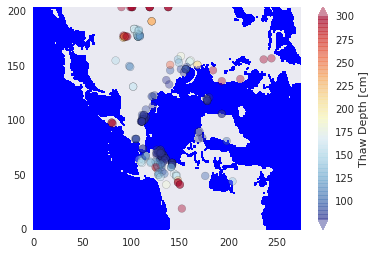

In [42]:
# fig, ax = plt.subplots(figsize=(7, 5), subplot_kw=dict(projection=Rasm()))

domain_file_unmasked = xr.open_dataset(os.path.join(workdir, 'domain.lnd.wr50a_ar9v4.130607.nc'))
domain_file_unmasked.mask.where(domain_file_unmasked.mask == 0).plot(add_colorbar=False, 
                                                                                cmap=plt.cm.winter, 
                                                                                add_labels=False,
                                                                                )
# ax.coastlines(resolution='50m', lw=0.5, color='k')

'''gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='-')'''

# g1 = ax.coastlines(resolution='50m', lw=0.5, color='k')

# use scatterplot
simulated_thaw_depths = sim_thaw_depths.mask.where(sim_thaw_depths.mask > 0)
img = plt.scatter(ni_inds, 
            nj_inds,
            c=thaw_depth_list, 
            s=60,
            cmap=plt.cm.RdYlBu_r,
            marker='o', 
            alpha=0.4, 
            vmin=80, 
            vmax=300, 
            )
plt.colorbar(img, label='Thaw Depth [cm]', extend='both')

plotname = 'simulated_thaw_depths_spatial.png'
savepath = os.path.join(workdir, 'plots')
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

In [43]:
thaw_depths = pd.read_csv(os.path.join(workdir, thaw_depths_file), 
                          delimiter=',', 
                         header=None, 
                         error_bad_lines=False, 
                         nrows=236, 
                         encoding='ISO-8859-1')

def replace_dash_with_nan(x): 
    '''this function replaces hyphens in the observed thaw depth time series with NaNs'''
    # print(type(x))
    if (type(x) == str):
        if ('-' in x):
            return np.nan
        elif thaw_depths.iloc[99][18][0] in x: 
            return(x.replace(thaw_depths.iloc[99][18][0], ""))
        elif x == ' ':
            return np.nan
        else: 
            return x
    else: 
        return np.nan
    
thaw_depths_filtered = thaw_depths.applymap(replace_dash_with_nan)
# print(thaw_depths_filtered.iloc[181][6] == ' ')
thaw_depths_observed = []

for latlng in np.arange(0, thaw_depths_filtered.shape[0]):
    thaw_depth_observed = np.nanmean(np.array(thaw_depths_filtered.iloc[latlng]).astype(float))
    thaw_depths_observed = np.append(thaw_depths_observed, thaw_depth_observed)

/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarn

observed thaw depths

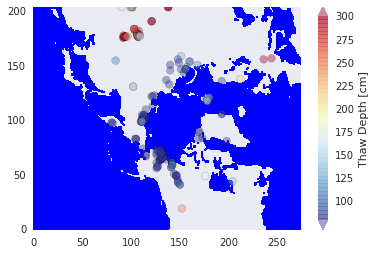

In [44]:
domain_file_unmasked = xr.open_dataset(os.path.join(workdir, 'domain.lnd.wr50a_ar9v4.130607.nc'))
domain_file_unmasked.mask.where(domain_file_unmasked.mask == 0).plot(add_colorbar=False, cmap=plt.cm.winter, 
                                                                     add_labels=False)

# use scatterplot
simulated_thaw_depths = sim_thaw_depths.mask.where(sim_thaw_depths.mask > 0)
img = plt.scatter(np.array(ni_inds)[~np.isnan(thaw_depths_observed)].tolist(), 
            np.array(nj_inds)[~np.isnan(thaw_depths_observed)].tolist(),
            c=thaw_depths_observed[~np.isnan(thaw_depths_observed)].tolist(), 
            s=60,
            cmap=plt.cm.RdYlBu_r,
            marker='o', 
            alpha=0.4, 
            vmin=80, 
            vmax=300)
plt.colorbar(img, label='Thaw Depth [cm]', extend='both')

plotname = 'observed_thaw_depths_spatial.png'
savepath = os.path.join(workdir, 'plots')
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

difference bw simulated and observed thaw depths 

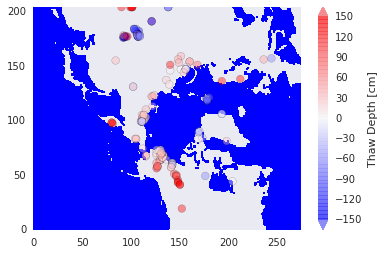

In [45]:
domain_file_unmasked = xr.open_dataset(os.path.join(workdir, 'domain.lnd.wr50a_ar9v4.130607.nc'))
domain_file_unmasked.mask.where(domain_file_unmasked.mask == 0).plot(add_colorbar=False, cmap=plt.cm.winter, 
                                                                     add_labels=False)

# use scatterplot
sim_minus_observed = ((np.array(thaw_depth_list)[~np.isnan(thaw_depths_observed)]) - 
                      (thaw_depths_observed[~np.isnan(thaw_depths_observed)])).tolist()
simulated_thaw_depths = sim_thaw_depths.mask.where(sim_thaw_depths.mask > 0)
img = plt.scatter(np.array(ni_inds)[~np.isnan(thaw_depths_observed)].tolist(), 
            np.array(nj_inds)[~np.isnan(thaw_depths_observed)].tolist(),
            c=sim_minus_observed, 
            s=60,
            cmap=plt.cm.bwr,
            marker='o', 
            alpha=0.4, 
            vmin=-150, 
            vmax=150)
plt.colorbar(img, label='Thaw Depth [cm]', extend='both')

plotname = 'difference_thaw_depths_spatial.png'
savepath = os.path.join(workdir, 'plots')
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

soil temperature profiles for Barrow, Alaska

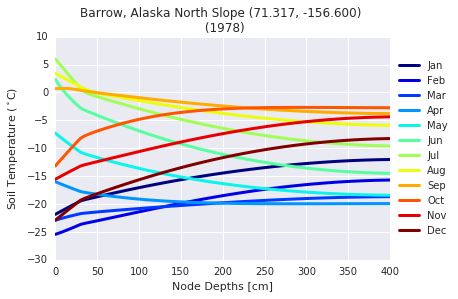

In [46]:
barrow_lat = 71.316667
barrow_lng = 203.400000
lw = 3.0

min_arg = (((domain.xc - barrow_lng)**2) + ((domain.yc - barrow_lat)**2)).argmin()
nj_ind, ni_ind = np.unravel_index(min_arg, domain.xc.shape)
node_depths_barrow = node_state.node_depth[:, nj_ind, ni_ind] * 100.0 
colors = plt.matplotlib.cm.jet(np.linspace(0,1,12))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for mo_num in np.arange(0, 12):
    label = '%s' % months[mo_num]
    plt.plot(node_depths_barrow,
             mo_fluxes.OUT_SOIL_TNODE[:, :, nj_ind, ni_ind].sel(time=slice('1978-01-01', '1978-12-31'))[mo_num], 
             color=colors[mo_num], 
             label=label, 
             linewidth=lw)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Barrow, Alaska North Slope (71.317, -156.600) \n (1978)')
plt.ylabel('Soil Temperature ($^\circ$C)')
plt.xlabel('Node Depths [cm]')

plotname = 'simulated_soil_temperatures_barrow.png'
savepath = os.path.join(workdir, 'plots')
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

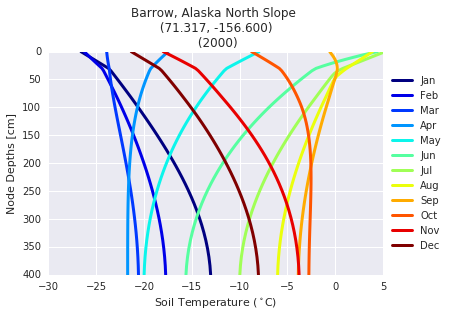

In [37]:
barrow_lat = 71.316667
barrow_lng = 203.400000
lw = 3.0

min_arg = (((domain.xc - barrow_lng)**2) + ((domain.yc - barrow_lat)**2)).argmin()
nj_ind, ni_ind = np.unravel_index(min_arg, domain.xc.shape)
node_depths_barrow = node_state.node_depth[:, nj_ind, ni_ind] * 100.0 
colors = plt.matplotlib.cm.jet(np.linspace(0,1,12))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for mo_num in np.arange(0, 12):
    label = '%s' % months[mo_num]
    plt.plot(mo_fluxes.OUT_SOIL_TNODE[:, :, nj_ind, ni_ind].sel(time=slice('2000-01-01', '2000-12-31'))[mo_num], 
             node_depths_barrow,
             color=colors[mo_num], 
             label=label, 
             linewidth=lw)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Barrow, Alaska North Slope \n (71.317, -156.600) \n (2000)')
plt.xlabel('Soil Temperature ($^\circ$C)')
plt.ylabel('Node Depths [cm]')
plt.ylim([400, 0])
plt.xlim([-30, 5])

plotname = 'simulated_soil_temperatures_barrow.png'
savepath = os.path.join(workdir, 'plots')
if not os.path.exists(savepath):
    os.makedirs(savepath)
plt.savefig(os.path.join(savepath, plotname), format='png', dpi=dpi, bbox_inches='tight')

In [38]:
print(dpi)

200


In [39]:
sim_thaw_depths.mask.where(sim_thaw_depths.mask > 0).ni

<xarray.DataArray 'ni' (ni: 275)>
array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173

In [40]:
node_state.node_depth

<xarray.DataArray 'node_depth' (soil_node: 50, nj: 205, ni: 275)>
[2818750 values with dtype=float64]
Coordinates:
  * ni         (ni) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * nj         (nj) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * soil_node  (soil_node) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
Attributes:
    long_name: node_depth
    standard_name: soil_thermal_node_depth
    units: m